In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [4]:
#Shor's Algorithm Qiskit: https://learn.qiskit.org/course/ch-algorithms/shors-algorithm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


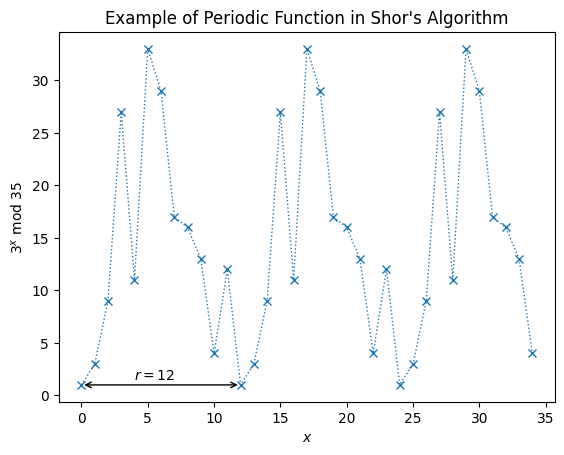

In [5]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

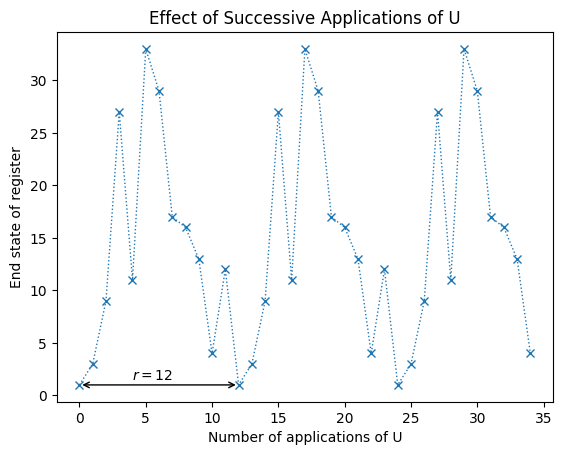

In [6]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [7]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [8]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [9]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

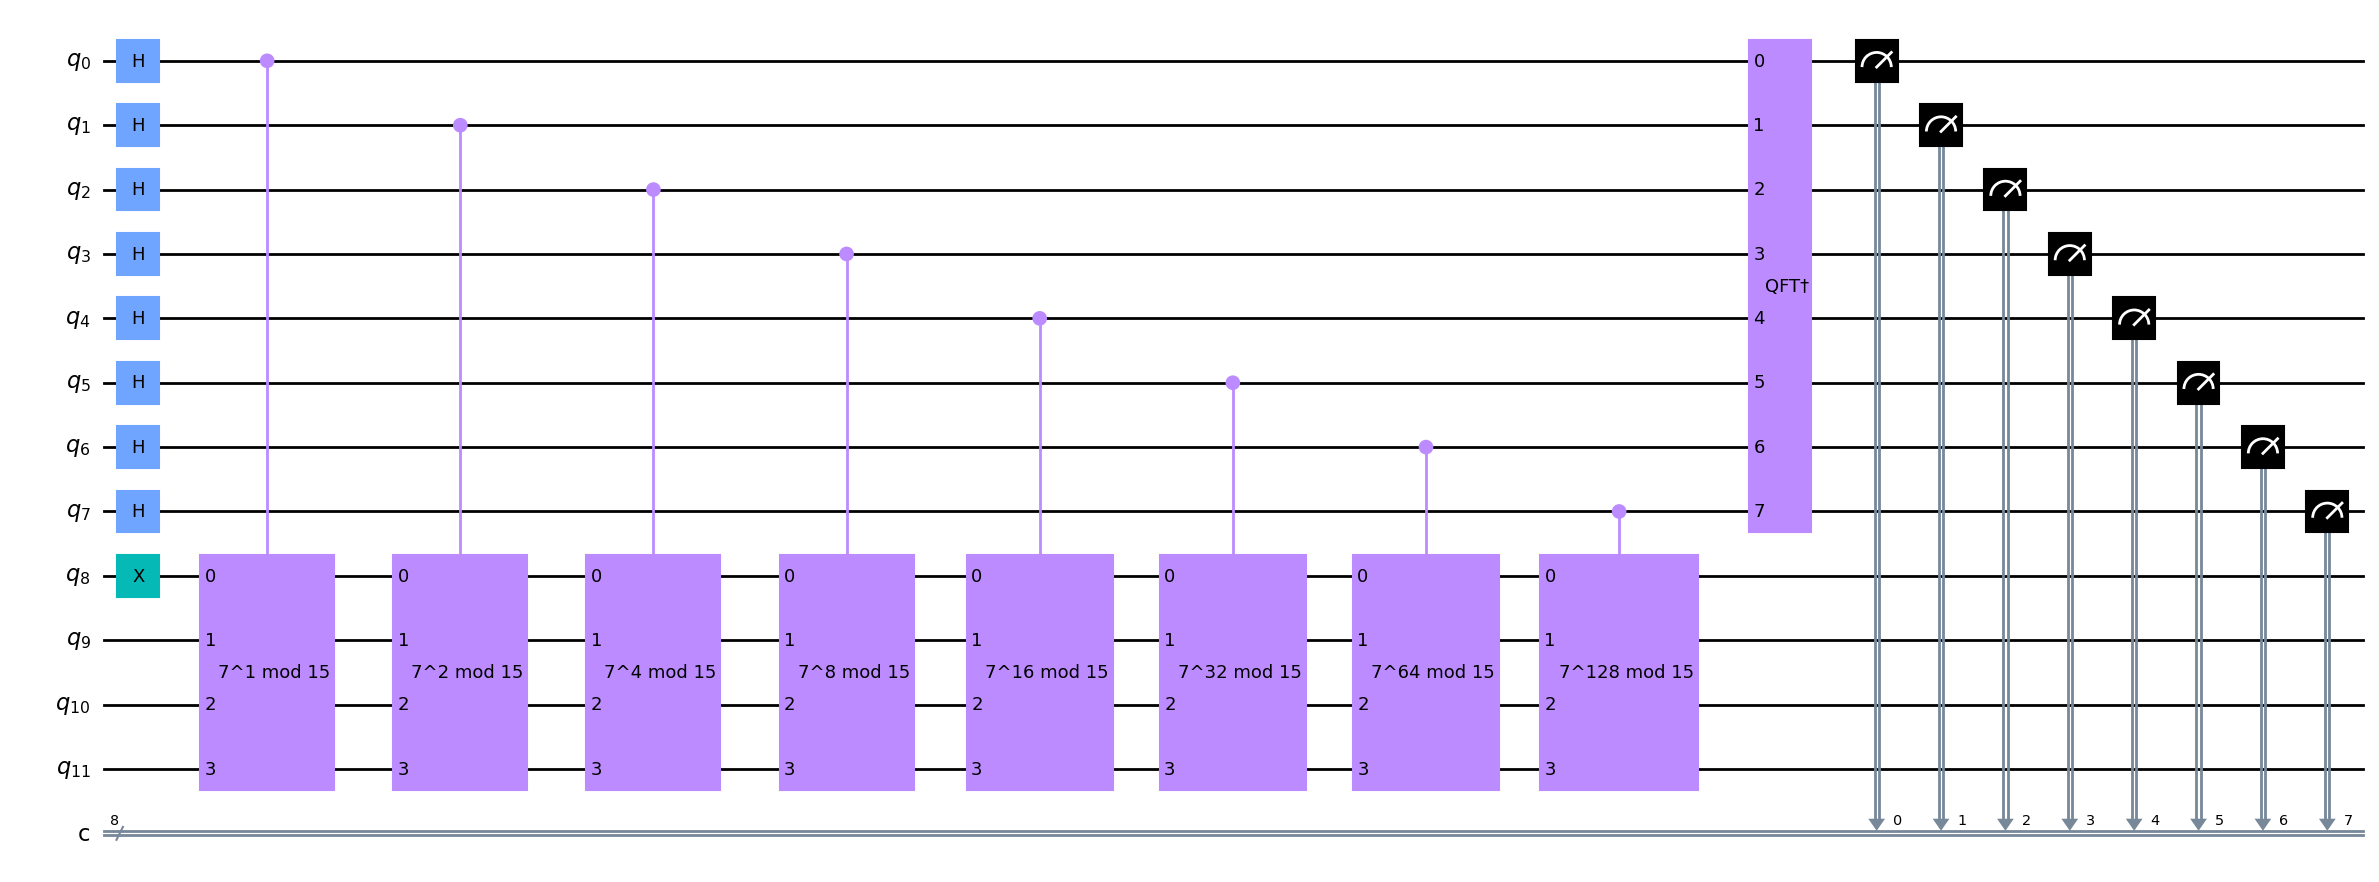

In [10]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

In [32]:
# Running checks for the correct dependencies
import qiskit
from packaging import version

if not (
    version.parse(qiskit.__qiskit_version__["qiskit-terra"]) >= version.parse("0.22")
):
    print(
        "Incorrect dependencies. Found qiskit-terra: "
        + qiskit.__qiskit_version__["qiskit-terra"]
        + "\nNeed qiskit-terra >= 0.22"
    )

try:
    import qiskit_ibm_provider
except ModuleNotFoundError:
    print(
        "You must install the qiskit_ibm_provider with 'pip install qiskit_ibm_provider'"
    )
    raise

In [33]:
# Ignoring warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [34]:
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
hub = "ibm-q"
group = "open"
project = "main"
backend_name = "ibm_brisbane"
hgp = f"{hub}/{group}/{project}"

In [35]:
import qiskit
from qiskit_ibm_provider import IBMProvider

# Save token if necessary
IBMProvider.save_account(overwrite=True,token='your_api_key_here')

# Get our backend
provider = IBMProvider()
available_backends = provider.backends()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

Using backend ibm_brisbane


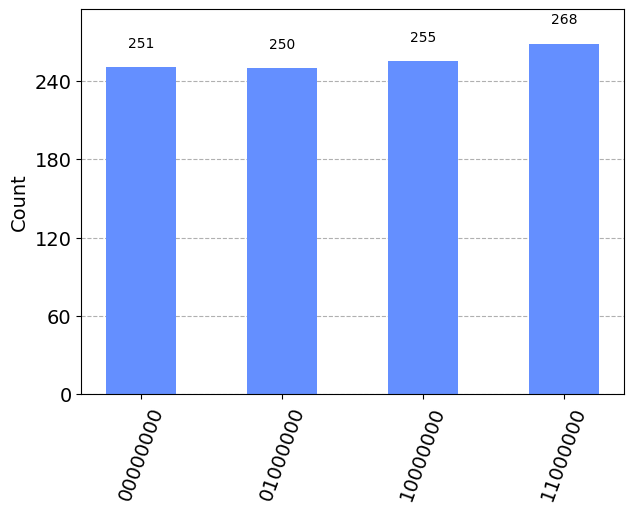

In [36]:
#aer_sim = Aer.get_backend('aer_simulator')
#t_qc = transpile(qc, aer_sim)
t_qc = transpile(qc, backend)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [37]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  01000000(bin) =  64(dec)   64/256 = 0.25
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [38]:
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [39]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.75      3/4            4
3   0.50      1/2            2


In [40]:
#modular exponentiation is the bottleneck
#implement repeated squaring algorithm for U^{2^j}
#check here: https://arxiv.org/abs/quant-ph/0205095
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [41]:
a2jmodN(7, 2049, 53)

47

In [42]:
N = 15

In [43]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [44]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [51]:
#quantum phase estimation for N=15 with manual U gates
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    #aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = backend.run(transpile(qc, backend), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [ ]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

In [47]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [48]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 10000000
Corresponding Phase: 0.5
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: {guess} ***
